# Semantic segmentation

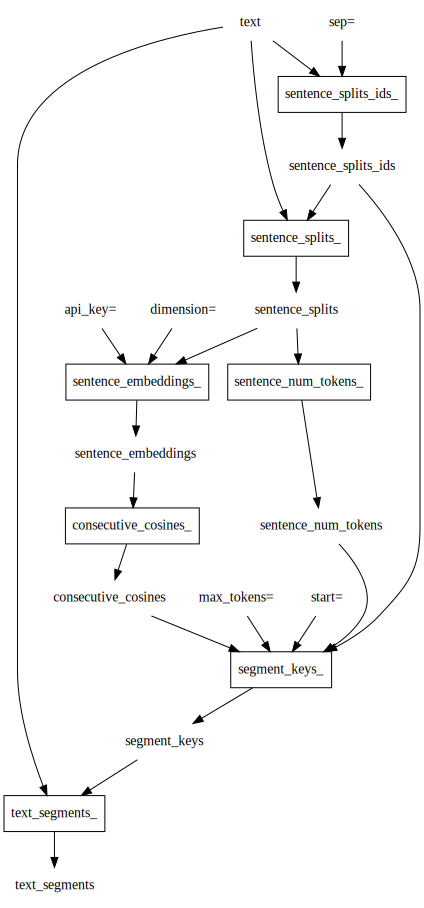

In [2]:
from raglab.retrieval.segmentation_lib import segmentation_dag
segmentation_dag[:"text_segments"].dot_digraph()

In [23]:
my_text = """
              Pierre aime jouer au football et lire des livres. Il passe beaucoup de temps à la bibliothèque. C'est un lieux idéal pour lui pour se détendre.\n

            La seconde guerre mondiale a effectivement été un désastre.
              Beacoup de livres ont été écrits sur ce sujet. Il suffit de parcourir les rayons de la bibliothèque pour s'en rendre compte.\n
            
              English is a language that is spoken by many people.
              Because of the British Empire, English has become a global language.
              During the World War II, the British Empire was at its peak"""


In [ ]:
segmentation_dag[:](text = my_text, max_tokens = 50)                 

In [2]:
from raglab.retrieval.segmentation_lib import character_chunker
character_chunker(text = my_text, max_chunk_size= 10)

[(0, 64),
 (64, 110),
 (110, 158),
 (158, 279),
 (279, 339),
 (339, 400),
 (400, 480),
 (480, 543),
 (543, 626),
 (626, 700)]

# Retrieval functions

In [2]:
from raglab.retrieval.lib_alexis import dag, generate_split_keys
doc_embeddings = dag[:"doc_embeddings"]
top_k = dag["user_query":"top_k_segments"]

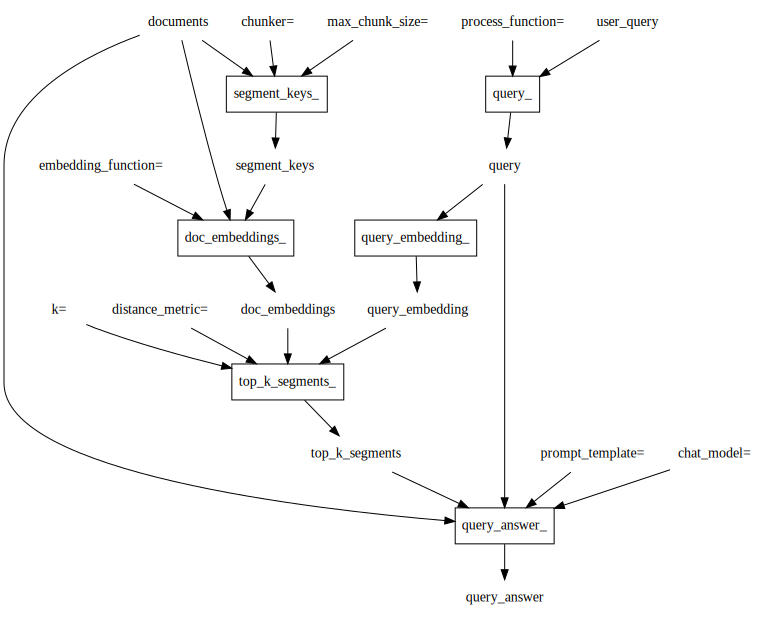

In [2]:
dag.dot_digraph()

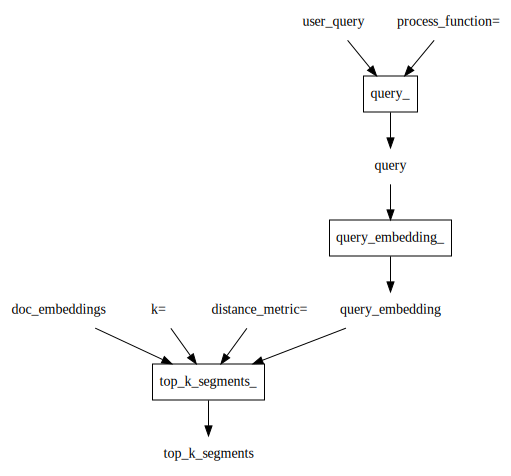

In [9]:
top_k.dot_digraph()

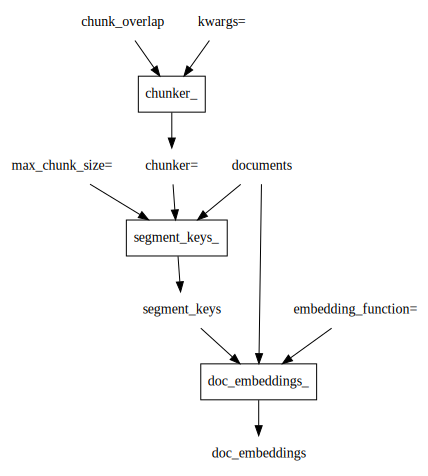

In [10]:
doc_embeddings.dot_digraph()

# Testing

test data

In [18]:
from dol import Files
from raglab.retrieval.lib_alexis import extension_base_wrap
test_responces = extension_base_wrap(Files("./data_ad/QA"))
test_documents = extension_base_wrap(Files("./data_ad/test_documents"))
print(f"test repsonces", list(test_responces))
print(f"test documents", list(test_documents))

test repsonces ['eval1.json', 'story_qa.json', 'mix_wiki.json']
test documents ['mix_wiki.txt', 'Contrat_ONE1406.pdf', 'story.txt', 'contract1.txt', 'writers.txt']


In [19]:
test_doc = {"contract": test_documents["contract1.txt"],
            "wiki" : test_documents["mix_wiki.txt"]
            }
test_qa = {**test_responces["eval1.json"], **test_responces["mix_wiki.json"]}


In [65]:
test_text = "\n".join([test_doc["contract"], test_doc["wiki"]])

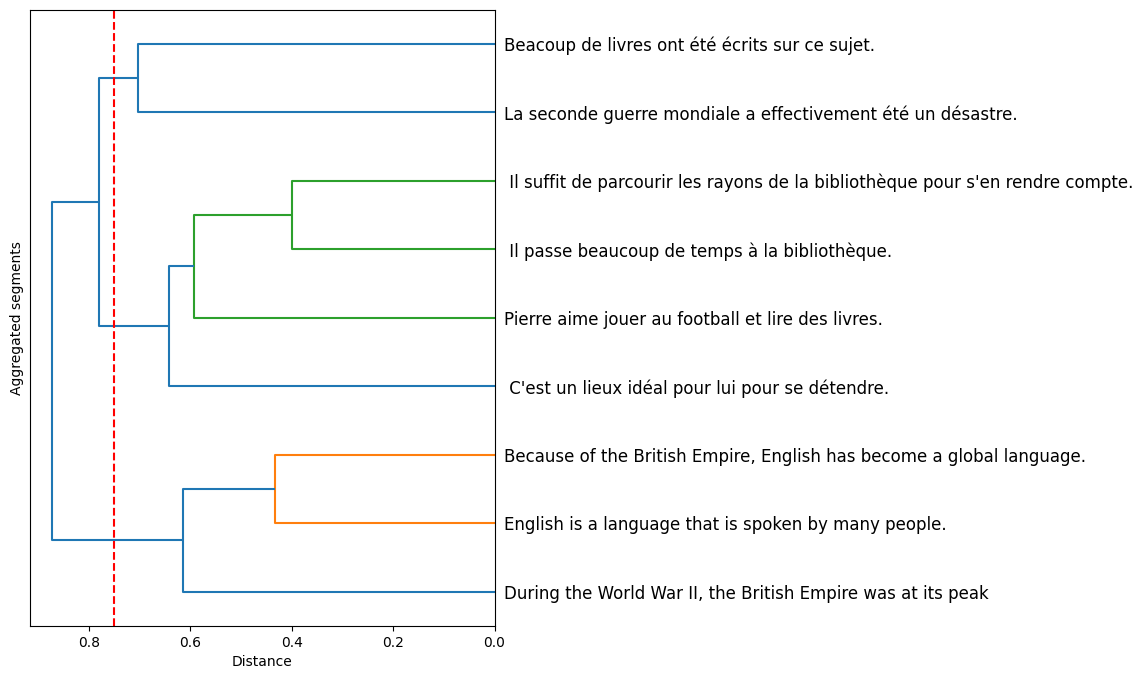

In [28]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

sentence_splits = segmentation_dag[:"sentence_splits"](text = my_text)
embeddings = segmentation_dag[:"sentence_embeddings"](text=my_text)
# Assume embeddings is already computed
# embeddings = segmentation_dag[:"sentence_embeddings"](text=my_text)

# Perform hierarchical clustering
Z = linkage(embeddings, metric='cosine', method='average')

# Create a figure for the dendrogram
fig = plt.figure(figsize=(6, 8))

def func_label(i):
    return sentence_splits[i].replace("\n", "").replace("  ", "")

# Generate the dendrogram with horizontal orientation
dn = dendrogram(Z, distance_sort=True, show_leaf_counts=True, orientation='left', leaf_label_func=func_label)

# Add labels and show the plot

# Add a horizontal line at a specific distance threshold
plt.axvline(x=0.75, color='r', linestyle='--')

# Add labels and show the plot
plt.xlabel("Distance")
plt.ylabel("Aggregated segments")
plt.show()


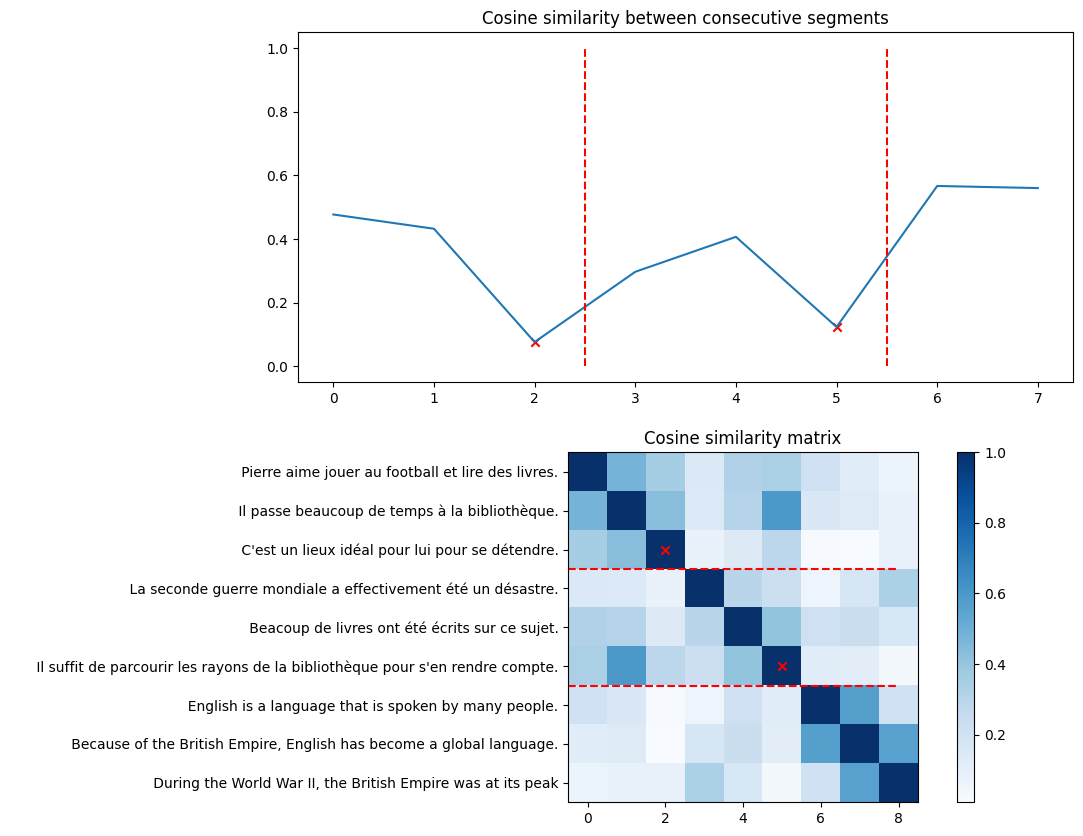

In [25]:
# display segmentation
segmentation_dag[:"display_cut_ids"](text=my_text, max_tokens=80)

In [35]:
112*5

560

In [28]:
from functools import partial
_generate_split_keys =  partial(generate_split_keys, chunk_overlap=40, max_chunk_size=10_000)

In [11]:
# import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
a= [[0, 1, 0], [0, 2, 0]]
cosine_similarity(a)

array([[1., 1.],
       [1., 1.]])

In [26]:
from raglab.retrieval.segmentation_lib import character_chunker

In [31]:
def semantic_doc_chunker(docs, max_chunk_size):
    segment_keys = []
    for doc_name, doc_txt in docs.items():
        sk = segmentation_dag[:"segment_keys"](text=doc_txt, max_tokens=max_chunk_size)
        for start, stop in sk:
            segment_keys.append((doc_name, start, stop))
    return segment_keys


In [61]:
from raglab.retrieval.lib_alexis import num_tokens, tokens
def size_chunker(text, max_chunk_size):
    segment_keys = []
    avg_token_size = len(text)// num_tokens(text)
    max_chars = max_chunk_size * avg_token_size
    for start in range(0, len(text), max_chars):
        stop = start + max_chars
        if stop > len(text):
            stop = len(text)
        segment_keys.append((start, stop))
    return segment_keys

def size_doc_chunker(docs, max_chunk_size):
    segment_keys = []
    for doc_name, doc_txt in docs.items():
        sk = size_chunker(text=doc_txt, max_chunk_size=max_chunk_size)
        for start, stop in sk:
            segment_keys.append((doc_name, start, stop))
    return segment_keys

size_chunker("""Voilà la recette de la tarte aux pomme. Il s'agit de la recetted de ma rand mere. Je l'aime beacoup. Ma grand mere""", 10)

[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 114)]

In [24]:
def char_doc_chunker(docs, max_chunk_size):
    segment_keys = []
    for doc_name, doc_txt in docs.items():
        sk = character_chunker(text=doc_txt, max_chunk_size=max_chunk_size)
        for start, stop in sk:
            segment_keys.append((doc_name, start, stop))
    return segment_keys

TODO for mean embedding aggregation

In [21]:
from raglab.suggestion_engine.suggestion_lib import set_from_text
def test_retrieval(chunker, max_chunk_size, verbose=False):
    doc_embed = doc_embeddings["chunker":](documents=test_doc, chunker = chunker, max_chunk_size=max_chunk_size)
    score = 0
    precision = 0
    recall = 0
    for query, responce in test_qa.items():
        if verbose:
            print(f"\n-------------\n Query: {query}")
            print(f"Expected: {responce}")
        True_set = set_from_text(responce)
        res = top_k(user_query=query, k=1, doc_embeddings=doc_embed)
        segment_key=res[0]
        predicted_set = set_from_text(test_doc[res[0][0]][res[0][1]:res[0][2]])
        precision += len(True_set.intersection(predicted_set)) / len(predicted_set)
        recall += len(True_set.intersection(predicted_set)) / len(True_set)
        if responce in test_doc[segment_key[0]][segment_key[1]:segment_key[2]]:
            score += 1
        if verbose:
            print(f"Predicted: {test_doc[segment_key[0]][segment_key[1]:segment_key[2]]}")

    print(f"precision: {precision/len(test_qa)}")
    print(f"recall: {recall/len(test_qa)}")
    print(f"\nScore: {score}/{len(test_qa)}")
    return precision/len(test_qa), recall/len(test_qa), score/len(test_qa)

In [62]:
max_sizes = [ 200, 300, 400, 500, 600, 700]
precisions = []
recalls = []
scores = []
#chunker = semantic_doc_chunker
#chunker = char_doc_chunker
chunker = size_doc_chunker
for max_size in max_sizes:
    p,r,s = test_retrieval(chunker, max_size)
    precisions.append(p)
    recalls.append(r)
    scores.append(s)

precision: 0.08429981873364333
recall: 0.5642965214348785

Score: 10/28
precision: 0.07759046473694277
recall: 0.7483079489724007

Score: 16/28
precision: 0.07579448073135339
recall: 0.7999283924095953

Score: 18/28
precision: 0.0571827282599373
recall: 0.8163579913995196

Score: 20/28
precision: 0.045437656154196183
recall: 0.6688122923588039

Score: 16/28
precision: 0.04995394570402432
recall: 0.8087835134053621

Score: 17/28


In [63]:
si_precisions = precisions
si_recalls = recalls
si_scores = scores

In [33]:
s_precisions = precisions
s_recalls = recalls
s_scores = scores

In [29]:
c_precisions = precisions
c_recalls = recalls
c_scores = scores

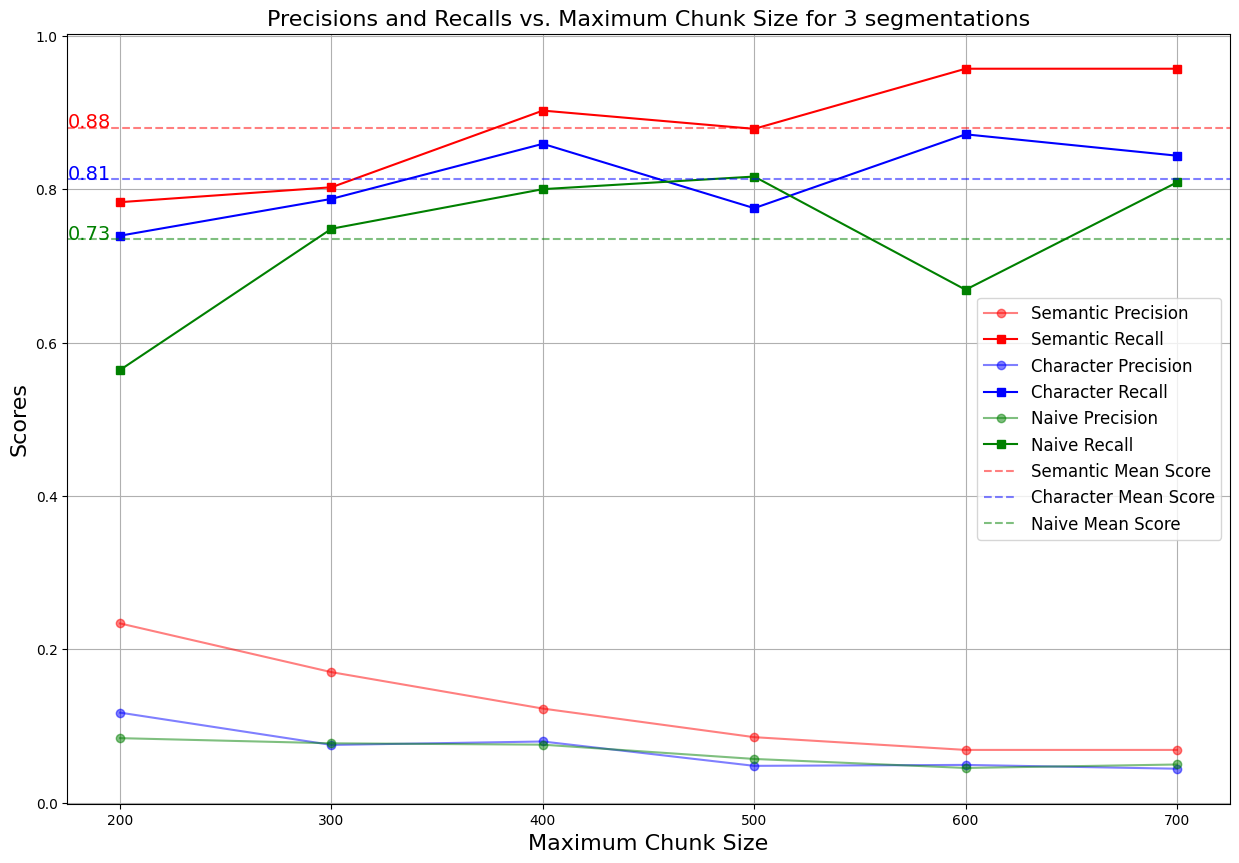

In [84]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(max_sizes, s_precisions, label="Semantic Precision", color="red", marker='o', alpha=0.5)
plt.plot(max_sizes, s_recalls, label="Semantic Recall", color="red", marker='s')
#plt.plot(max_sizes, s_scores, label="Semantic Score", color="red", marker='^')

plt.plot(max_sizes, c_precisions, label="Character Precision", linestyle="-", color="blue", marker='o', alpha=0.5)
plt.plot(max_sizes, c_recalls, label="Character Recall", linestyle="-", color="blue", marker='s')
#plt.plot(max_sizes, c_scores, label="Character Score", linestyle="--", color="blue", marker='^')

plt.plot(max_sizes, si_precisions, label="Naive Precision", linestyle="-", color="green", marker='o', alpha=0.5)
plt.plot(max_sizes, si_recalls, label="Naive Recall", linestyle="-", color="green", marker='s')
#plt.plot(max_sizes, si_scores, label="Naive Score", linestyle=":", color="green", marker='^')

# Adding labels and title
plt.xlabel("Maximum Chunk Size", fontsize=16)
plt.ylabel("Scores", fontsize=16)
plt.title("Precisions and Recalls vs. Maximum Chunk Size for 3 segmentations", fontsize=16)

# add mean lines and there hints
plt.axhline(y=sum(s_recalls)/len(s_scores), color='red', linestyle='--', label='Semantic Mean Score', alpha=0.5)
plt.axhline(y=sum(c_recalls)/len(c_scores), color='blue', linestyle='--', label='Character Mean Score', alpha=0.5)
plt.axhline(y=sum(si_recalls)/len(si_scores), color='green', linestyle='--', label='Naive Mean Score', alpha=0.5)
# right means values
plt.text(max_sizes[0]-25, sum(s_recalls)/len(s_scores), f"{sum(s_recalls)/len(s_scores):.2f}", color='red', fontsize=14)
plt.text(max_sizes[0]-25, sum(c_recalls)/len(c_scores), f"{sum(c_recalls)/len(c_scores):.2f}", color='blue', fontsize=14)
plt.text(max_sizes[0]-25, sum(si_recalls)/len(si_scores), f"{sum(si_recalls)/len(si_scores):.2f}", color='green', fontsize=14)


# Adding grid
plt.grid(True)

# Adding legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


# visualize embeddings

In [39]:
# dump .tsv file to save vectors
vectors = list(doc_embed.values()) + dag["user_query":"query_embedding"](user_query="Une personne qui habite une ville côtière")
labels = list(doc_embed.keys()) + ["Une personne qui habite une ville côtière"]


In [34]:
"a \n".replace("\n", "")

'a '

In [44]:
# visualisation of embaddings with labels
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(list(doc_embed.values()))
sentences = [d[key[0]][key[1]:key[2]] for key in doc_embed.keys()]
print(len(principalComponents), len(sentences))
sentence_embd = zip(sentences, principalComponents)
with open("embeddings_story.tsv", "w") as f:
    with open("embeddings_metadata_story.tsv", "w") as fm:
        for k, v in sentence_embd :
            fm.write(k.replace("\n", "") + "\n")
            f.write("\t".join([str(x).replace("\n", "") for x in v]) + "\n")
            print(v,k)


25 25
[ 0.263606   -0.16116216  0.24300912] Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à
[ 0.15252536 -0.03040171 -0.14722567] chercher des coquillages brillants et à construire des châteaux de sable.
[ 0.32028301 -0.09492968  0.2574581 ] Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa
[ 0.21093002  0.05010822 -0.19036478] pour voir ce qu'elle contenait. À sa grande surprise, une petite carte était enroulée à l'intérieur.
[ 0.2480553   0.02308763 -0.13970906] La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à l'aventure pour trouver le trésor.
[0.31339917 0.07151561 0.13113321] Il marcha à trave

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00505012 -0.01125633  0.02729863 ... -0.01323909 -0.01103879
 -0.01737863].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
for k in doc_embed:
    print(d[k[0]][k[1]:k[2]])
    print("\n")

Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre.


vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à


ses journées à explorer les plages, à chercher des coquillages brillants et à construire des


brillants et à construire des châteaux de sable.


Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée


une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour


avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa grande surprise, une petite


À sa grande surprise, une petite carte était enroulée à l'intérieur.


La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles.


un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à


découverte, Pierre décida de partir à l'aventure pour trouver le trésor.


Il marcha à travers la